# Simple edge and contour detection on stone tools

Notebook discussed in meeting of 22 November 2020.

## Library instalations

For a quick-and-dirty implementation, lets install the needed libraries here (for further work we must use an environment). We are using Python 3 in this notebook.

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} scikit-image
!pip install matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

You should consider upgrading via the '/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import skimage
import skimage.feature
import skimage.viewer
import sys
import matplotlib.pyplot as plt
from skimage import filters
from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum
from skimage.measure import find_contours

/anaconda3/envs/vivarium_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Viewer requires Qt
  This is separate from the ipykernel package so we can avoid doing imports until


## Proof of concept 

Using edge contour detection to count fractures and scars in a drawing of a stone tool.

### Image processing

In the next steps we will read an image and apply some processing steps.

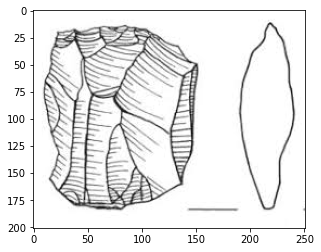

In [3]:
filename = 'images.jpeg'

#an alternative image
#filename = 'axeillus.jpg'

# load and display original image as grayscale
image = skimage.io.imread(fname=filename, as_gray=True)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)


## Count fractures

### Binary thresholding 

Thresholding is used to create a binary image from a grayscale image. 
It is the simplest way to segment objects from a background. 

The simplest thresholding methods replace each pixel in an image with a black pixel if the image intensity  is less than some fixed constant T, or a white pixel if the image intensity is greater than that constant.

In here we will use it select only the main fractures. 

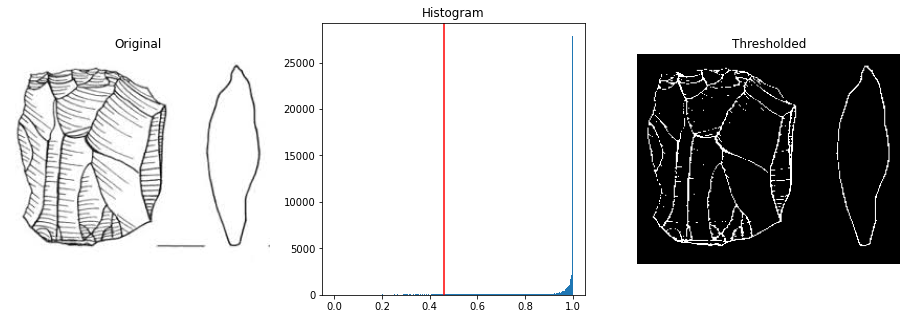

In [4]:
thresh = threshold_minimum(image)
thresh = thresh + thresh*0.2

binary = image < thresh 

fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

This thresholding seems to eliminate most of the scars and leave the larger fractures (which is what we want). 
Now lets see if we can detect these fracture lines using edge detection.

### Edge detection

Edge operators are used in image processing within edge detection algorithms. They are discrete differentiation operators, computing an approximation of the gradient of the image intensity function.

Different operators compute different finite-difference approximations of the gradient.

https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html?highlight=edge%20detection.

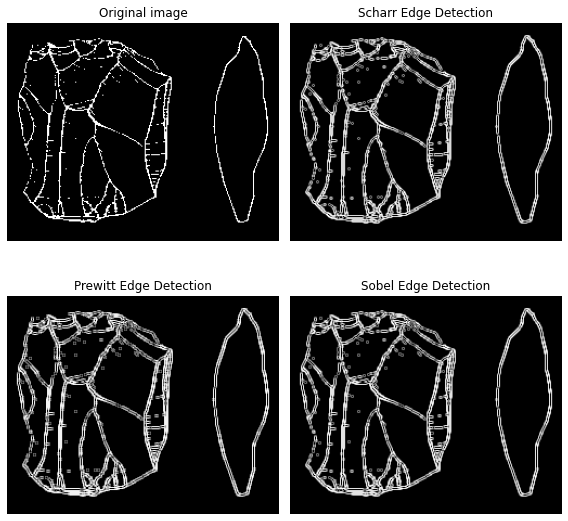

In [5]:
from skimage.util import compare_images
import numpy as np


edge_sobel = filters.sobel(binary)
edge_scharr = filters.scharr(binary)
edge_prewitt = filters.prewitt(binary)


fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(binary, cmap=plt.cm.gray)
axes[0].set_title('Original image')

axes[1].imshow(edge_scharr, cmap=plt.cm.gray)
axes[1].set_title('Scharr Edge Detection')

axes[2].imshow(edge_prewitt, cmap=plt.cm.gray)
axes[2].set_title('Prewitt Edge Detection')

axes[3].imshow(edge_sobel, cmap=plt.cm.gray)
axes[3].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Contour finding

Find constant valued contours in an image. Array values are linearly interpolated to provide better precision of the output contours. Contours which intersect the image edge are open; all others are closed.

https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html

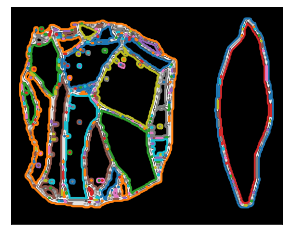

Numer of contours: 349


In [11]:
# Find contours at a constant value of 0.8
contours = find_contours(edge_sobel, 0.1,fully_connected='low')

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(edge_sobel, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

print ('Numer of contours:', len(contours))

Let's only select the largest contours that correspond to what we are looking for.

In [12]:
# Only select contours with more than 80 pixels
new_countours = []
for cont in contours:
    if cont.shape[0]<80:
        continue
    else:
        new_countours.append(cont)
        
new_countours = np.array(new_countours)

print ('Numer of contours:', len(new_countours))

Numer of contours: 14


/anaconda3/envs/vivarium_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


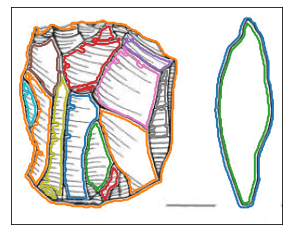

In [13]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for contour in new_countours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Count scars 

Now let's try to count the scars present in a contour. 

### Select a contour and mask it on the image

In [ ]:
import scipy.ndimage as ndimage    

contour = new_countours[6]
#contour = new_countours[19]

# Create an empty image to store the masked array
r_mask = np.zeros_like(image, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
r_mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
r_mask = ndimage.binary_fill_holes(r_mask)

# Invert the mask since you want pixels outside of the region
new_image = np.multiply(r_mask,image)

new_image = new_image 

In [ ]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(new_image, cmap=plt.cm.gray)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Binary thresholding

Oposite to the previous step, lets use binary thresholding to highlight the scars.

In [ ]:
from skimage.filters import threshold_multiotsu

thresh = threshold_minimum(new_image)
binary_sub_image = new_image > 0.9 


fig, axes = plt.subplots(ncols=3, figsize=(16, 4.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(new_image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(new_image.ravel(), bins=256)
ax[1].set_yscale('log')
ax[1].set_title('Histogram')
ax[1].axvline(0.9, color='r')

ax[2].imshow(binary_sub_image, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Edge detection on scars using ridge filters

Ridge filters can be used to detect ridge-like structures, such as neurites, tubes, vessels, wrinkles or rivers.

Different ridge filters may be suited for detecting different structures, e.g., depending on contrast or noise level.

https://scikit-image.org/docs/dev/auto_examples/edges/plot_ridge_filter.html

In [ ]:
# Find contours at a constant value of 0.8
edge_sato = filters.sato(binary_sub_image,sigmas=range(1, 2, 1))

   
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(binary_sub_image, cmap=plt.cm.gray)
ax.imshow(edge_sato, cmap=plt.cm.gray)

    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Find contours to count scars

Again, let's use contour finding to now find the scars and count them.

In [ ]:
contours = find_contours(edge_sato, 0.19,fully_connected='high')

fig, ax = plt.subplots()
ax.imshow(binary_sub_image, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
print ('Number of scars:',len(contours))

there are some very small contours, let's select only the ones that are relevant to us.

In [ ]:
fig, ax = plt.subplots()
ax.imshow(binary_sub_image, cmap=plt.cm.gray)

new_contour_scars = []
for contour in contours:
    if len(contour)<10:
        continue
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    new_contour_scars.append(contour)
print ('Number of scars:',len(contours))

## Summary:

It is possible to count fractures and scars using image processing tecniques. However, the performance of this process depend a lot of the image and the parameters used.

* Binary thresholding: choose the right algoritm and threshold for the right problem (fractures != scares)
* Edge detection: choose the right algorithm for the right problem (fractures != scares), optimise parameters based on the input image. 
* Contour finding: Optimise parameters based on the problem (fractures != scars), the previous steps can have a big effect in which parameters we must use.

These are parameters tuned for a single image, we need to find the optimal parameter for a group of images. 